# Preprocessing

In [ ]:
# Link below contains information about building an environment from a .YML file
# Make sure to activate the environment before opening the notebook
# https://shandou.medium.com/export-and-create-conda-environment-with-yml-5de619fe5a2

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

In [2]:
import os

def readFile(wd, filename):
    try:    
        path = os.path.join(wd, "data", filename)
        file = pd.read_csv(path)
    except FileNotFoundError:
        print("Could not read file - Please check filepath")
        raise
    return file

wd = os.getcwd()
train = readFile(wd, "training_data.csv")
test = readFile(wd, "eval_data.csv")

## Pre-processing

pre-process the sessions (you can execute these tasks in the order you prefer, but make sure to specify which task is being solved in which block of code):
1. sessionise <font color='red'>(1pt)</font>
1. select sessions with at least one add-to-cart <font color='red'>(1pt)</font>
1. add class labels: treat purchase as the positive class <font color='red'>(1pt)</font>
1. cut purchase sessions to the last event before the first purchase <font color='red'>(1pt)</font>
1. remove sessions shorter than 5 and longer than 155 clicks <font color='red'>(1pt)</font>
1. symbolise actions <font color='red'>(1pt)</font>


In [3]:
# Sessionise:
# derive sessions from action by action dataset
# merge all the actions by session_id

def sessionize(df):
    df['product_action'] = df['product_action'].fillna('view')
    df = df.groupby('session_id_hash')['product_action'].agg(list).reset_index()
    return df

train = sessionize(train)
test = sessionize(test)

In [4]:
##  Label purchase sessions

def labelSet(df):
    df['purchase'] = np.where(df.product_action.map(set(['purchase']).issubset), 1, 0)
    return df

train = labelSet(train)
test = labelSet(test)

In [5]:
### Cut actions before purchase if there is one
### keep the full sesssion if there is not

def sliceSessions(df):
    df['product_action'] = df['product_action'].map(lambda x: x[0:x.index('purchase')] if 'purchase' in x else x)

    ## select sessions with at least one add-to-cart
    df = df[df.product_action.map(lambda x: "add" in x)]

    ### Filtered out outliers which > 155 or < 5.    

    df["len"] = df["product_action"].map(len)

    # removing very short and very long sessions
    df.drop(df[df.len < 5].index, inplace=True)
    df.drop(df[df.len > 155].index, inplace=True)
    
    return df

train = sliceSessions(train)
test = sliceSessions(test)

In [6]:
## Sanity check: the output should be True
def checkFaultySessions(df):
    print(df[df.product_action.map(lambda x: "add" not in x)].shape[0])
    
checkFaultySessions(train)
checkFaultySessions(test)

0
0


In [7]:
## symbolise actions, based on practical session 1
from collections import Counter
def symbolize(df, symbol2idx=None):
    sessions = df['product_action'].to_list()
    labels = df['purchase'].to_list()
    
    if symbol2idx == None:
        counts = Counter([item for session in sessions for item in session])
        symbol2idx = {symbol: idx for idx, symbol in enumerate(sorted(counts, key=counts.get, reverse=True), 1)}
        print("Symbol alphabet: ", symbol2idx)

    df["session"]=df["product_action"].map(lambda session: [symbol2idx[s] for s in session])
    
    return df, symbol2idx

train, symbol2idx = symbolize(train)
test, _ = symbolize(test, symbol2idx)
test.head()

Symbol alphabet:  {'view': 1, 'detail': 2, 'add': 3, 'remove': 4}


,session_id_hash,product_action,purchase,len,session
1,000010504025397b03290c7457e0e7ef7ae93529f21eae...,"[detail, view, detail, view, detail, view, vie...",0,81,"[2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, ..."
35,0002cc06d46d4835503b88e9eed2c8fc1ae97f5cc262a9...,"[view, detail, detail, view, add, view, view, ...",0,18,"[1, 2, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, ..."
40,00030ffeaf340fe2ef44c91bca1a7cffd5f07d1a44a081...,"[view, detail, add, view, remove, add, remove,...",0,28,"[1, 2, 3, 1, 4, 3, 4, 1, 1, 1, 2, 1, 2, 1, 2, ..."
58,0004be10f232d2ebd86be1c1c46dcf741ee77651bc550d...,"[view, view, view, view, view, view, view, det...",0,15,"[1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 2, 3, 1]"
74,0005ea00d00f64fbfaaa8b110f268025ba8ad963d8fdd3...,"[view, view, view, view, view, view, detail, v...",0,50,"[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, ..."


In [8]:
## Check the symbolisation
symbol2idx

{'view': 1, 'detail': 2, 'add': 3, 'remove': 4}

## Oracle model

In [9]:
from sklearn import metrics

def oracle(X_train, y_train):
    '''
    This function return a oracle model based on the session and label.
    '''
    from collections import defaultdict

    d = defaultdict(lambda: defaultdict(int))
    for s, l in zip(X_train, y_train):
        d[str(tuple(s))][l] += 1
        
    model = {}
    for session in d.keys():
        n_buy, n_ws = 0, 0
        for label in d[session].keys():
            if label:
                n_buy += d[session][label]
            else:
                n_ws += d[session][label]
        model[session] = n_buy / (n_buy + n_ws)
        
    return model

def oracle_predict(model, X_test, y_test=None):
    '''
    1. Make prediction on X_test.
    2. For possibility >0.5 predict 1, else 0.
    3. return prediction and F1 score
    '''

    y_pred = []
    for x in X_test:
        pos = model.get(str(x), "#") ## For sessions that not in the model, we assign it to #, and then predict 0.
        y_pred.append(pos)
        
    ## count "#" first and substitute with 0
    missing_rate = y_pred.count("#")/len(y_pred)

    y_pred = [1 if y != "#" and y >= 0.5 else 0 for y in y_pred]
        
    if y_test is not None:
#         y_test = y_test.to_list()
        f1 = metrics.f1_score(y_test, y_pred)
        return(f1, missing_rate,y_pred)
    else:
        return y_pred

In [10]:
## Oracle model for 5 clicks
## Subset from the original test
i = 5
data = test[["session", "purchase"]]
data.session = test.session.map(lambda x: x[:x.index(3)+1+i] if len(x[x.index(3)+1:])>=i else None)
data.session = test.session.map(tuple)
data = data.dropna()
    
model = oracle(data.session, data.purchase)
f1, missing_rate, prediction = oracle_predict(model, data.session, data.purchase)
f1

0.8706342991386061

In [11]:
# oracle model for 10 clicks
i = 10
data = test[["session", "purchase"]]
data.session = test.session.map(lambda x: x[:x.index(3)+1+i] if len(x[x.index(3)+1:])>=i else None)
data.session = test.session.map(tuple)
data = data.dropna()
    
model = oracle(data.session, data.purchase)
f1, missing_rate, prediction = oracle_predict(model, data.session, data.purchase)
f1

0.8706342991386061

In [12]:
# oracle model for 15 clicks
i = 15
data = test[["session", "purchase"]]
data.session = test.session.map(lambda x: x[:x.index(3)+1+i] if len(x[x.index(3)+1:])>=i else None)
data.session = test.session.map(tuple)
data = data.dropna()
    
model = oracle(data.session, data.purchase)
f1, missing_rate, prediction = oracle_predict(model, data.session, data.purchase)
f1

0.8706342991386061

## Subset by post-add-to-cart

1. Subset data for n-click (n=5, 10, 15) models.

In [13]:
## Get dataframe subsets
## make the prediction for 5, 10 and 15, and store the f1 it in a dict
from collections import defaultdict

def makeSubset(df):
    data = defaultdict(lambda: defaultdict())
    
    for i in [5, 10, 15]:    
        ## Subset from the original df
        temp = df[["session", "purchase"]]
        temp.session = temp.session.map(lambda x: x[:x.index(3)+1+i] if len(x[x.index(3)+1:])>=i else None)
        temp = temp.dropna()
        
        data[f"{i}_clicks"]["X"] = temp.session.to_numpy()
        data[f"{i}_clicks"]["Y"] = temp.purchase.to_numpy()
    
    return data

train_data = makeSubset(train)
test_data = makeSubset(test)

In [14]:
train_size = pd.DataFrame(train_data).applymap(len)
test_size = pd.DataFrame(test_data).applymap(len)
print(train_size)
print(test_size)

   5_clicks  10_clicks  15_clicks
X    107767      75887      55270
Y    107767      75887      55270
   5_clicks  10_clicks  15_clicks
X     24969      17424      12704
Y     24969      17424      12704


## Naive Bayes Model

In [15]:
## Encode ngrams, code from practical session 2
def ngram_featurizer(session, n=3):
    
    """takes in a list and an integer defining the size of ngrams.
     Returns the ngrams of desired size in the input string"""
    
    session = ['#']*(n-1) + session + ['+']*(n-1)
    ngrams = [tuple(session[i:i+n]) for i in range(len(session)-n+1)]
    
    return ngrams
    

def encode_sessions(sessions,n=3, mapping=None):
    
    """
    Takes in a list of lists, an integer indicating the character ngrams' size,
    and a dictionary mapping ngrams to numerical indices. If no dictionary is passed,
    one is created inside the function.
    The function outputs a 2d NumPy array with as many rows as there are strings in 
    the input list, and the mapping from ngrams to indices, representing the columns 
    of the NumPy array.
    """
    
    if not mapping:
        all_ngrams = set()
        for session in sessions:
            all_ngrams = all_ngrams.union(set(ngram_featurizer(session, n)))
    
        mapping = {ngram: i for i, ngram in enumerate(all_ngrams)}
    
    X = np.zeros((len(sessions), len(mapping)))
    for i, session in enumerate(sessions):
        for ngram in ngram_featurizer(session, n):
            try:
                X[i, mapping[ngram]] += 1
            except KeyError:
                pass
    
    return X, mapping

In [16]:
from sklearn.naive_bayes import MultinomialNB

score = {}
for i in [5,10,15]:
    sessions_train = train_data[f"{i}_clicks"]["X"]
    labels_train = train_data[f"{i}_clicks"]["Y"]
    
    sessions_test = test_data[f"{i}_clicks"]["X"]
    labels_test = test_data[f"{i}_clicks"]["Y"]

    Xtrain, mapping = encode_sessions(sessions_train)
    Xtest, _ = encode_sessions(sessions_test, mapping=mapping)

    NB = MultinomialNB(alpha=1, fit_prior=True)
    NB.fit(Xtrain,labels_train)
    bayes_predictions = NB.predict(Xtest)
    
    f1 = metrics.f1_score(labels_test, bayes_predictions)
    
    score[f"F1_{i}-clicks"] = f1

In [17]:
print(score)

{'F1_5-clicks': 0.3124876701519037, 'F1_10-clicks': 0.356648541769649, 'F1_15-clicks': 0.3699518032241981}


## Advanced Model: XGBoost Classifier

### 5-clicks

In [39]:
##################################5 CLICKS  XGBOOST MODEL ################################
### Get the copy of the data
from sklearn.utils import resample
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
def xgboost_model(n_click = '5_clicks', downsample = True):
    
    X_train = train_data[n_click]['X']
    y_train = train_data[n_click]['Y']
    X_test = test_data[n_click]['X']
    y_test = test_data[n_click]['Y']
    
    if downsample == True:  ##### If downsample is set to True, this part will run and resample the data
        ### Downsampling the training data
        ### And keep the test data in shape
        temp = pd.DataFrame({"session": X_train, 'purchase': y_train})

        class_0 = temp[temp.purchase == 0]
        class_1 = temp[temp.purchase == 1]

        class_0 = resample(class_0,
                     replace=True,
                     n_samples=len(class_1),
                     random_state=123)


        data_downsampled = pd.concat([class_0, class_1])

        X_train = data_downsampled.session
        y_train = data_downsampled.purchase
    ### Featurization
    ## Doing ngrams with n = 1 AND 2

    one_gram, mapping_1 = encode_sessions(X_train,n=1, mapping=None)
    two_gram, mapping_2 = encode_sessions(X_train,n=2, mapping=None)

    mapping_2 = {key: value + len(mapping_1) for key,value in mapping_2.items()}
    mapping = {**mapping_1, **mapping_2}
    X_train = np.concatenate((one_gram, two_gram), axis=1)

    # featurize X_test
    X = np.zeros((len(X_test), len(mapping)))
    for i, session in enumerate(X_test):
        for ngram in ngram_featurizer(session, 1) + ngram_featurizer(session, 2):
            try:
                X[i, mapping[ngram]] += 1
            except KeyError:
                pass
    X_test = X
    
    param_grid = {
        'gamma': [0], 
        'learning_rate': [0.05], 
        'max_depth': [5, 6, 7],
        'reg_lambda': [9.0, 10.0, 11.0],
        'scale_pos_weight': [1]}

    optimal_params = GridSearchCV(
        estimator=XGBClassifier(objective='binary:logistic',
                                    seed=123,
                                    subsample=0.9,
                                    colsample_bytree=0.5),
        param_grid=param_grid,
        scoring='f1',
        verbose = 0,
        n_jobs = 5,
        cv = 3
    )

    optimal_params.fit(X_train,
                      y_train,
                      early_stopping_rounds=10,
                      eval_metric='aucpr',
                      eval_set=[(X_test, y_test)],
                      verbose=False)
    preds = optimal_params.predict(X_test)

    f1 = metrics.f1_score(y_test, preds)
    
    #Create and return a dataframe 
    
    output = pd.DataFrame(data=preds, columns=['Predicted Labels'])
    output['True Labels'] = y_test
    output['Predicted == True'] = np.where(output["Predicted Labels"] == output['True Labels'], 1, 0)
    output['Session Length'] = [len(x) for x in test_data[n_click]['X']]
    
    return output

#### Featurization & Downsampling

#### Model Train and Predict

In [42]:
###Dataframe output from xgboost functions for data without downsampling
click15_nodown = xgboost_model(n_click = '15_clicks', downsample= False)
click10_nodown = xgboost_model(n_click = '10_clicks', downsample = False)
click5_nodown = xgboost_model(n_click = '5_clicks', downsample = False)

In [43]:
###Dataframe output from xgboost functions for data with downsampling
click15_down = xgboost_model(n_click = '15_clicks', downsample = True)
click10_down = xgboost_model(n_click = '10_clicks', downsample = True)
clicks5_down = xgboost_model(n_click = '5_clicks', downsample = True)

F1 scores:  0.1748456288592785 0.12850999241082722 0.08750963762528913


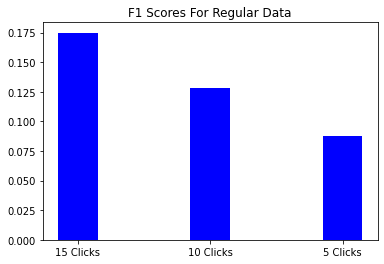

In [44]:
##Plot for not resampled data
import sklearn.metrics

f1_15 = metrics.f1_score(click15_nodown['True Labels'], click15_nodown['Predicted Labels'])
f1_10 = metrics.f1_score(click10_nodown['True Labels'], click10_nodown['Predicted Labels'])
f1_5 = metrics.f1_score(click5_nodown['True Labels'], click5_nodown['Predicted Labels'])
print('F1 scores: ', f1_15, f1_10, f1_5)
w = 0.3
clicks = ['15 Clicks', '10 Clicks', '5 Clicks']
f1s = [f1_15, f1_10, f1_5]
ax = plt.subplot()
ax.bar(clicks, f1s, width=w, color='b', align='center'), plt.title('F1 Scores For Regular Data')
plt.show()

F1 scores:  0.3991689390988183 0.3872163856272623 0.36119013750592704


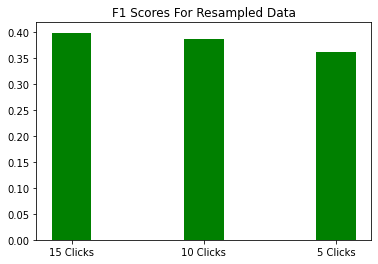

In [45]:
####Plot for Resampled Data
f1_15_2 = metrics.f1_score(click15_down['True Labels'], click15_down['Predicted Labels'])
f1_10_2 = metrics.f1_score(click10_down['True Labels'], click10_down['Predicted Labels'])
f1_5_2 = metrics.f1_score(clicks5_down['True Labels'], clicks5_down['Predicted Labels'])

print('F1 scores: ', f1_15_2, f1_10_2, f1_5_2)
w = 0.3
clicks = ['15 Clicks', '10 Clicks', '5 Clicks']
f1s_2 = [f1_15_2, f1_10_2, f1_5_2]
ax = plt.subplot()
ax.bar(clicks, f1s_2, width=w, color='g', align='center'), plt.title('F1 Scores For Resampled Data')
plt.show()

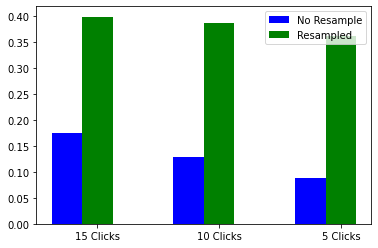

In [46]:
###Plot to compare resampled and regular data
x = np.arange(3)
fig = plt.figure()
ax = plt.subplot()
ax.bar(x, f1s, color = 'b', width = 0.25)
ax.bar(x + 0.25, f1s_2, color = 'g', width = 0.25, tick_label = ['15 Clicks', '10 Clicks', '5 Clicks'])
ax.legend(labels=['No Resample', 'Resampled'])

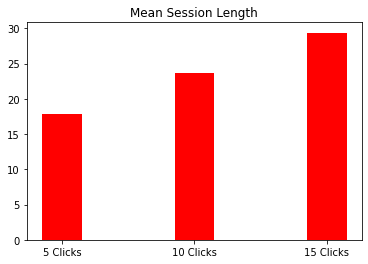

In [47]:
#Mean session length + plot
session_5 = click5_nodown['Session Length'].mean()
session_10 = click10_nodown['Session Length'].mean()
session_15 = click15_nodown['Session Length'].mean()

w = 0.3
sessions = [session_5, session_10, session_15]
clicks = ['5 Clicks', '10 Clicks', '15 Clicks']
ax = plt.subplot()
ax.bar(clicks, sessions, width=w, color='r', align='center'), plt.title('Mean Session Length')
plt.show()

In [48]:
## ROUND 1
# param_grid = {
#     'max_depth': [3,4,5],
#     'learning_rate': [0.1,0.01,0.05],
#     'gamma': [0,0.25,1.0],
#     'reg_lambda': [0,1.0, 10.0],
#     'scale_pos_weight': [1,3,5]
# }

# RESULT of the first Round:
#        {'gamma': 0, 
#         'learning_rate': 0.05, 
#         'max_depth': 5, 
#         'reg_lambda': 10.0, 
#         'scale_pos_weight': 1}

## Round 2
param_grid = {
        'gamma': [0], 
        'learning_rate': [0.05], 
        'max_depth': [5, 6, 7],
        'reg_lambda': [9.0, 10.0, 11.0],
        'scale_pos_weight': [1]}

optimal_params = GridSearchCV(
    estimator=XGBClassifier(objective='binary:logistic',
                                seed=123,
                                subsample=0.9,
                                colsample_bytree=0.5),
    param_grid=param_grid,
    scoring='f1',
    verbose = 0,
    n_jobs = 5,
    cv = 3
)

optimal_params.fit(X_train,
                   y_train,
                  early_stopping_rounds=10,
                  eval_metric='aucpr',
                  eval_set=[(X_test, y_test)],
                  verbose=False)
print(optimal_params.best_params_)

{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'reg_lambda': 10.0, 'scale_pos_weight': 1}


In [49]:
## Fit and Predict
preds = optimal_params.predict(X_test)

f1 = metrics.f1_score(y_test, preds)

f1

0.36119013750592704

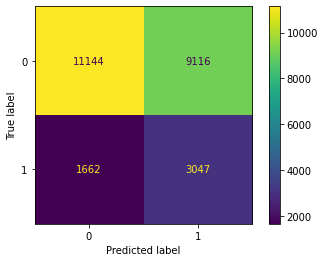

In [50]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(optimal_params,
                      X_test,
                      y_test,
                      values_format='d')

In [51]:
# Grab results for error analysis in R
output_5_clicks = pd.DataFrame(data=preds, columns=['Predicted Labels'])
output_5_clicks['True Labels'] = y_test
output_5_clicks['Predicted == True'] = np.where(output_5_clicks["Predicted Labels"] == output_5_clicks['True Labels'], 1, 0)
output_5_clicks['Session Length'] = [len(x) for x in test_data['5_clicks']['X']]

output_5_clicks.head(5)

,Predicted Labels,True Labels,Predicted == True,Session Length
0,0,0,1,28
1,1,0,0,10
2,0,0,1,8
3,1,0,0,15
4,0,0,1,35


In [52]:
#Save output as a csv
path = os.path.join(wd, "data", "5_clicks_no_downsample.csv")
output_5_clicks.to_csv(path)

### 10-clicks

#### Featurization & Downsampling

In [54]:
### Get the copy of the data
i = '10_clicks'
X_train = train_data[i]['X']
y_train = train_data[i]['Y']
X_test = test_data[i]['X']
y_test = test_data[i]['Y']

### Downsampling the training data
### And keep the test data in shape
temp = pd.DataFrame({"session": X_train, 'purchase': y_train})

class_0 = temp[temp.purchase == 0]
class_1 = temp[temp.purchase == 1]

class_0 = resample(class_0,
             replace=True,
             n_samples=len(class_1),
             random_state=123)


data_downsampled = pd.concat([class_0, class_1])

X_train = data_downsampled.session
y_train = data_downsampled.purchase

### Featurization
## Doing ngrams with n = 1 AND 2

one_gram, maping_1 = encode_sessions(X_train,n=1, mapping=None)
two_gram, maping_2 = encode_sessions(X_train,n=2, mapping=None)

maping_2 = {key: value + len(maping_1) for key,value in maping_2.items()}
maping = {**maping_1, **maping_2}
X_train = np.concatenate((one_gram, two_gram), axis=1)

# featurize X_test
X = np.zeros((len(X_test), len(maping)))
for i, session in enumerate(X_test):
    for ngram in ngram_featurizer(session, 1) + ngram_featurizer(session, 2):
        try:
            X[i, maping[ngram]] += 1
        except KeyError:
            pass
X_test = X

#### Model Train and Predict

In [55]:
# ROUND 1
# param_grid = {
#     'max_depth': [3,4,5],
#     'learning_rate': [0.1,0.01,0.05],
#     'gamma': [0,0.25,1.0],
#     'reg_lambda': [0,1.0, 10.0],
#     'scale_pos_weight': [1,3,5]
# }

# RESULT of the first Round:
#        {'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 10.0, 'scale_pos_weight': 3}

## Round 2
param_grid = {
        'gamma': [1], 
        'learning_rate': [0.1], 
        'max_depth': [4],
        'reg_lambda': [9.0, 10.0, 11.0],
        'scale_pos_weight': [3]}

optimal_params = GridSearchCV(
    estimator = XGBClassifier(objective='binary:logistic',
                                seed=123,
                                subsample=0.9,
                                colsample_bytree=0.5),
    param_grid=param_grid,
    scoring='f1',
    verbose = 0,
    n_jobs = 5,
    cv = 3
)

optimal_params.fit(X_train,
                   y_train,
                  early_stopping_rounds=10,
                  eval_metric='aucpr',
                  eval_set=[(X_test, y_test)],
                  verbose=False)
print(optimal_params.best_params_)

{'gamma': 1, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 9.0, 'scale_pos_weight': 3}


In [56]:
## Fit and Predict
preds = optimal_params.predict(X_test)
f1 = metrics.f1_score(y_test, preds)
f1

0.335458128558221

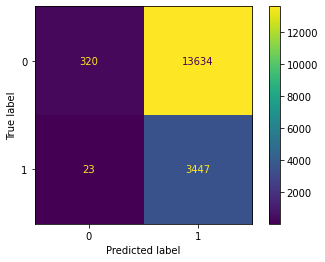

In [57]:
## Plot the confusion metrics
plot_confusion_matrix(optimal_params,
                      X_test,
                      y_test,
                      values_format='d')

In [58]:
output_10_clicks = pd.DataFrame(data=preds, columns=['Predicted Labels'])
output_10_clicks['True Labels'] = y_test
output_10_clicks['Predicted == True'] = np.where(output_10_clicks["Predicted Labels"] == \
                                                 output_10_clicks['True Labels'], 1, 0)
output_10_clicks['Session Length'] = [len(x) for x in test_data['10_clicks']['X']]

output_10_clicks.head(5)

,Predicted Labels,True Labels,Predicted == True,Session Length
0,1,0,0,33
1,1,0,0,15
2,1,0,0,13
3,1,0,0,40
4,1,0,0,13


In [59]:
#Save output as a csv
path = os.path.join(wd, "data", "10_clicks_downsampled.csv")
output_10_clicks.to_csv(path)

### 15-clicks

#### Featurization & Downsampling

In [60]:
### Get the copy of the data
i = '15_clicks'
X_train = train_data[i]['X']
y_train = train_data[i]['Y']
X_test = test_data[i]['X']
y_test = test_data[i]['Y']

### Downsampling the training data
### And keep the test data in shape
temp = pd.DataFrame({"session": X_train, 'purchase': y_train})

class_0 = temp[temp.purchase == 0]
class_1 = temp[temp.purchase == 1]

class_0 = resample(class_0,
             replace=True,
             n_samples=len(class_1),
             random_state=123)


data_downsampled = pd.concat([class_0, class_1])

X_train = data_downsampled.session
y_train = data_downsampled.purchase

### Featurization
## Doing ngrams with n = 1 AND 2

one_gram, maping_1 = encode_sessions(X_train,n=1, mapping=None)
two_gram, maping_2 = encode_sessions(X_train,n=2, mapping=None)

maping_2 = {key: value + len(maping_1) for key,value in maping_2.items()}
maping = {**maping_1, **maping_2}
X_train = np.concatenate((one_gram, two_gram), axis=1)

# featurize X_test
X = np.zeros((len(X_test), len(maping)))
for i, session in enumerate(X_test):
    for ngram in ngram_featurizer(session, 1) + ngram_featurizer(session, 2):
        try:
            X[i, maping[ngram]] += 1
        except KeyError:
            pass
X_test = X

#### Model Train and Predict

In [61]:
## ROUND 1
# param_grid = {
#     'max_depth': [3,4,5],
#     'learning_rate': [0.1,0.01,0.05],
#     'gamma': [0,0.25,1.0],
#     'reg_lambda': [0,1.0, 10.0],
#     'scale_pos_weight': [1,3,5]
# }

# RESULT of the first Round:
#       {'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 10.0, 'scale_pos_weight': 3}

## Round 2
# param_grid = {
#         'gamma': [0.25], 
#         'learning_rate': [0.1], 
#         'max_depth': [5, 6, 7],
#         'reg_lambda': [9.0, 10.0, 11.0],
#         'scale_pos_weight': [3]}

optimal_params = GridSearchCV(
    estimator=XGBClassifier(objective='binary:logistic',
                                seed=123,
                                subsample=0.9,
                                colsample_bytree=0.5),
    param_grid=param_grid,
    scoring='f1',
    verbose = 0,
    n_jobs = 5,
    cv = 3
)

optimal_params.fit(X_train,
                   y_train,
                  early_stopping_rounds=10,
                  eval_metric='aucpr',
                  eval_set=[(X_test, y_test)],
                  verbose=False)
print(optimal_params.best_params_)

{'gamma': 1, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 9.0, 'scale_pos_weight': 3}


In [62]:
## Fit and Predict
preds = optimal_params.predict(X_test)

f1 = metrics.f1_score(y_test, preds)

f1

0.3388543371522095

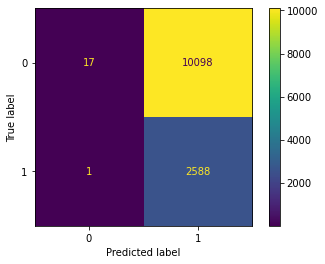

In [63]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(optimal_params,
                      X_test,
                      y_test,
                      values_format='d')

In [64]:
# Build 

output_15_clicks = pd.DataFrame(data=preds, columns=['Predicted Labels'])
output_15_clicks['True Labels'] = y_test
output_15_clicks['Predicted == True'] = np.where(output_15_clicks["Predicted Labels"] == \
                                                 output_15_clicks['True Labels'], 1, 0)
output_15_clicks['Session Length'] = [len(x) for x in test_data['15_clicks']['X']]
output_15_clicks.head(5)

,Predicted Labels,True Labels,Predicted == True,Session Length
0,1,0,0,38
1,1,0,0,18
2,1,0,0,45
3,1,0,0,18
4,1,0,0,18


In [65]:
#Save output as a csv
path = os.path.join(wd, "data", "15_clicks_downsampled.csv")
output_15_clicks.to_csv(path)

## Error Analysis in R

In [66]:
# pip install rpy2 to be able to run the following cells
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [22]:
%%R
# install the packges if this the first time running R on jupiter
install.packages("plyr", repos='http://cran.us.r-project.org')
install.packages("tidyverse", repos='http://cran.us.r-project.org')
install.packages("effects", repos='http://cran.us.r-project.org')
install.packages("broom", repos='http://cran.us.r-project.org')

In [67]:
%%R

library(plyr)
library(tidyverse)
library(effects)


Error: package or namespace load failed for 'tidyverse' in loadNamespace(j <- i[[1L]], c(lib.loc, .libPaths()), versionCheck = vI[[j]]):
 there is no package called 'reprex'


PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\tvand\\AppData\\Local\\Temp\\tmpbbn4jtis\\Rplots001.png'

In [ ]:
%%R
print(R.version.string)

## Set the correct working directory and import the files

In [ ]:
%%R 
# set the correct working directory where the 6 csv files are stored
setwd("D:/GroupAssignment/data/")

In [ ]:
%%R

X5_clicks_no_downsampled = read.table("5_clicks_no_downsample.csv", header = T, sep=',')
X10_clicks_no_downsampled = read.table("10_clicks_no_downsample.csv", header = T, sep=',')
X15_clicks_no_downsampled = read.table("15_clicks_no_downsampled.csv", header = T, sep=',')

In [ ]:
%%R

# cleaning and formatting the files
# the 5 clicks buy
X5_clicks_downsampled$X <- NULL
X5_clicks_downsampled$num_of_clicks <- "5_clicks"
colnames(X5_clicks_downsampled)[1] <- "Predicted_Labels"
colnames(X5_clicks_downsampled)[2] <- "True_Labels"
colnames(X5_clicks_downsampled)[3] <- "Accurate"
colnames(X5_clicks_downsampled)[4] <-  "Session_Length"

# the 10 clicks buy
X10_clicks_downsampled$X <- NULL
X10_clicks_downsampled$num_of_clicks <- "10_clicks"
colnames(X10_clicks_downsampled)[1] <- "Predicted_Labels"
colnames(X10_clicks_downsampled)[2] <- "True_Labels"
colnames(X10_clicks_downsampled)[3] <- "Accurate"
colnames(X10_clicks_downsampled)[4] <-  "Session_Length"

# the 15 clicks buy
X15_clicks_downsampled$X <- NULL
X15_clicks_downsampled$num_of_clicks <- "15_clicks"
colnames(X15_clicks_downsampled)[1] <- "Predicted_Labels"
colnames(X15_clicks_downsampled)[2] <- "True_Labels"
colnames(X15_clicks_downsampled)[3] <- "Accurate"
colnames(X15_clicks_downsampled)[4] <-  "Session_Length"

# the 5 clicks no buy
X5_clicks_no_downsampled$X <- NULL
X5_clicks_no_downsampled$num_of_clicks <- "5_clicks"
colnames(X5_clicks_no_downsampled)[1] <- "Predicted_Labels"
colnames(X5_clicks_no_downsampled)[2] <- "True_Labels"
colnames(X5_clicks_no_downsampled)[3] <- "Accurate"
colnames(X5_clicks_no_downsampled)[4] <-  "Session_Length"

# the 10 clicks no buy
X10_clicks_no_downsampled$X <- NULL
X10_clicks_no_downsampled$num_of_clicks <- "10_clicks"
colnames(X10_clicks_no_downsampled)[1] <- "Predicted_Labels"
colnames(X10_clicks_no_downsampled)[2] <- "True_Labels"
colnames(X10_clicks_no_downsampled)[3] <- "Accurate"
colnames(X10_clicks_no_downsampled)[4] <-  "Session_Length"

# the 15 clicks no buy
X15_clicks_no_downsampled$X <- NULL
X15_clicks_no_downsampled$num_of_clicks <- "15_clicks"
colnames(X15_clicks_no_downsampled)[1] <- "Predicted_Labels"
colnames(X15_clicks_no_downsampled)[2] <- "True_Labels"
colnames(X15_clicks_no_downsampled)[3] <- "Accurate"
colnames(X15_clicks_no_downsampled)[4] <-  "Session_Length"

## Combining the data frames

In [ ]:
%%R

# combine the 6 data frames to two buy and no_buy data frames
buy <- rbind(X5_clicks_downsampled, X10_clicks_downsampled, X15_clicks_downsampled)
no_buy <- rbind(X5_clicks_no_downsampled, X10_clicks_no_downsampled, X15_clicks_no_downsampled)

head(buy)

## Fitting the data frames in a logistic regression

In [ ]:
%%R

# test the logistic regression on the buy and no_buy data frames
buy_glm.fit <- glm(Accurate ~ True_Labels + Session_Length + num_of_clicks, data = buy, family = binomial)
no_buy_glm.fit <- glm(Accurate ~ True_Labels + Session_Length + num_of_clicks, data = no_buy, family = binomial)

In [ ]:
%%R

# summerizing the result for the buy group
summary(buy_glm.fit)

In [ ]:
%%R

# summerizing the result for the on_buy group
summary(no_buy_glm.fit)

## Making the plots

In [ ]:
%%R

# create the buy_plot 
buy_glm.fit.effects = as.data.frame(
  Effect(c("True_Labels", "Session_Length", "num_of_clicks"), buy_glm.fit,
         xlevels = list(Session_Length=sort(unique(buy$Session_Length))), 
         confidence.level=.99))

buy_glm.fit.effects$num_of_clicks =factor(buy_glm.fit.effects$num_of_clicks, 
                                      levels = c("5_clicks", "10_clicks", "15_clicks"))


buy_plot <- ggplot(data = buy_glm.fit.effects, aes(Session_Length, fit, color=num_of_clicks, fill=num_of_clicks)) +
                    geom_smooth() +
                    labs(y = 'Accuracy', x = "sequence length") +
                    ggtitle("buy_plot = uracy as a function of length, for diffrent numbers of clicks") +
                    scale_y_continuous(limits = c(0,1)) + 
                    scale_x_continuous(limits = c(5, 160)) +
                    theme(legend.direction = "horizontal", legend.position = "bottom", legend.box = "horizontal", legend.key.height = unit(0.5, "cm"), legend.key.width = unit(1, "cm"))

In [ ]:
%%R

# create the no_buy_plot 
no_buy_glm.fit.effects = as.data.frame(
  Effect(c("True_Labels", "Session_Length", "num_of_clicks"), no_buy_glm.fit,
         xlevels = list(Session_Length=sort(unique(no_buy$Session_Length))), 
         confidence.level=.99))

no_buy_glm.fit.effects$num_of_clicks =factor(no_buy_glm.fit.effects$num_of_clicks, 
                                      levels = c("5_clicks", "10_clicks", "15_clicks"))


no_buy_plot <- ggplot(data = no_buy_glm.fit.effects, aes(Session_Length, fit, color=num_of_clicks, fill=num_of_clicks)) +
                    geom_smooth() +
                    labs(y = 'Accuracy', x = "sequence length") +
                    ggtitle("no_buy_plot = Accuracy as a function of length, for diffrent numbers of clicks") +
                    scale_y_continuous(limits = c(0,1)) + 
                    scale_x_continuous(limits = c(5, 160)) +
                    theme(legend.direction = "horizontal", legend.position = "bottom", legend.box = "horizontal", legend.key.height = unit(0.5, "cm"), legend.key.width = unit(1, "cm"))

## Printing the Plots

In [ ]:
%%R
# print the plot
buy_plot

In [ ]:
%%R

# print the plot
no_buy_plot